In [1]:
import sys
sys.path.append('../')
from src.scoring_functions import *
from src.load_data import *
from plotnine import *

In [2]:
# from darts import TimeSeries
# from darts.utils.missing_values import fill_missing_values
# from darts.utils.statistics import plot_acf, plot_ccf, plot_pacf

In [3]:
import xarray as xr
from scores.stats import statistical_tests

In [4]:
from itertools import combinations

In [5]:
def custom_theme():
    return theme(
        plot_title=element_text(size=11),
        strip_text=element_text(size=10),
        legend_title=element_text(size=9),           
        legend_text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text_x=element_text(size=8, rotation=90, ha='center', ma='right'),
        axis_text_y=element_text(size=8)
    )

In [31]:
def compute_wis_raw(df):
    # Filter rows where 'quantile' is 0.5, rename 'value' to 'med', and drop unnecessary columns
    df_median = df[df['quantile'] == 0.5].copy()
    df_median = df_median.rename(columns={'value': 'med'}).drop(columns=['quantile', 'pathogen', 'retrospective', 'truth'], errors='ignore')

    # Filter rows where 'type' is 'quantile' and merge with df_median
    df_quantile = df[df['type'] == 'quantile'].copy()
    df = df_quantile.merge(df_median, how='left')

    # Compute scores and other metrics row-wise
    df['wis'] = df.apply(lambda row: score(row['value'], row['truth'], row['type'], row['quantile']), axis=1)
    df['spread'] = df.apply(lambda row: score(row['value'], row['med'], row['type'], row['quantile']), axis=1)
    df['overprediction'] = df.apply(lambda row: row['wis'] - row['spread'] if row['med'] > row['truth'] else 0, axis=1)
    df['underprediction'] = df.apply(lambda row: row['wis'] - row['spread'] if row['med'] < row['truth'] else 0, axis=1)
    
    return df

In [7]:
MODEL_COLORS = {
    'Ensemble': '#009E73',
    'LightGBM': '#B30000',
    'LightGBM-NoCovariates': '#B30000',
    'LightGBM-NoCovid': '#B30000',
    'LightGBM-Oracle': '#B30000',
    'LightGBM-Skip': '#B30000',
    'LightGBM-Uncorrected': '#B30000',
    'TSMixer': '#E69F00',
    'TSMixer-NoCovariates': '#E69F00',
    'TSMixer-NoCovid': '#E69F00',
    'TSMixer-Oracle': '#E69F00',
    'TSMixer-Skip': '#E69F00',
    'TSMixer-Uncorrected': '#E69F00',
    'hhh4': '#3C4AAD',
    'hhh4-NoCovid': '#3C4AAD',
    'hhh4-Oracle': '#3C4AAD',
    'hhh4-Shuffle': '#3C4AAD',
    'hhh4-Skip': '#3C4AAD',
    'hhh4-Uncorrected': '#3C4AAD',
    'TSCount-NB-S': '#69e2d1',
    'TSCount-Pois': '#69e2d1',
    'Nowcast': '#56B4E9',
    'Historical': '#000000',
    'Persistence' : '#80471C',
}

In [8]:
MODEL_ORDER = ['Nowcast', 'Ensemble', 
               'LightGBM', 'LightGBM-NoCovariates', 'LightGBM-NoCovid', 'LightGBM-Oracle', 'LightGBM-Skip', 'LightGBM-Uncorrected',
               'TSMixer', 'TSMixer-NoCovariates', 'TSMixer-NoCovid', 'TSMixer-Oracle', 'TSMixer-Skip', 'TSMixer-Uncorrected',
               'hhh4', 'hhh4-Shuffle', 'hhh4-NoCovid', 'hhh4-Oracle', 'hhh4-Skip', 'hhh4-Uncorrected', 'TSCount-NB-S', 'TSCount-Pois', 'Persistence', 'Historical']

In [9]:
MAIN_MODEL_ORDER = ['Ensemble', 'LightGBM', 'TSMixer', 'hhh4', 'Persistence', 'Historical']

In [61]:
MAIN_MODELS = ['Ensemble', 'LightGBM', 'TSMixer', 'hhh4', 'Historical', 'Persistence']

In [50]:
MAIN_MODEL_ORDER = ['hhh4', 'hhh4-Oracle', 'hhh4-Skip', 'hhh4-Uncorrected']

In [27]:
MAIN_MODELS = ['hhh4', 'hhh4-Oracle', 'hhh4-Skip', 'hhh4-Uncorrected']

In [28]:
df = load_predictions()

In [30]:
df = df[df.model.isin(MAIN_MODELS)].copy()
model_order = [m for m in MODEL_ORDER if m in df.model.unique()]
df['model'] = pd.Categorical(df['model'], categories=model_order, ordered=True) 

In [32]:
df_national = filter_by_level(df, 'national')

In [33]:
df_wis = compute_wis_raw(df_national)

In [34]:
df = df_wis.groupby(['location', 'age_group', 'model', 'date', 'horizon'], observed=True)['wis'].mean().reset_index()

In [36]:
df.date = pd.to_datetime(df.date)

In [40]:
df = df[df.horizon > 0]

In [69]:
df.isnull().sum()

location     0
age_group    0
model        0
date         0
horizon      0
wis          0
dtype: int64

In [77]:
df_results = pd.DataFrame()
for m1, m2 in combinations(MAIN_MODEL_ORDER, 2):
    print(f'{m1} vs {m2}')
    df_temp = df[df.model.isin([m1, m2])]
    df_temp = df_temp.pivot(index=['location', 'age_group', 'date', 'horizon'], 
                        columns='model', values='wis').rename_axis(columns=None).reset_index()
    df_temp['score_diff'] = df_temp[m1] - df_temp[m2]
    df_temp = (df_temp
               .pivot(index="date", columns="horizon", values="score_diff")
               .rename_axis(index="valid_date")      
               .sort_index()
               #.dropna()
              )
    
    da = xr.DataArray(
        data=df_temp.T.to_numpy(),              
        dims=["horizon", "valid_date"],
        coords={
            "horizon": df_temp.columns.astype(int),
            "valid_date": ("valid_date", pd.to_datetime(df_temp.index)),
            "h": ("horizon", df_temp.columns.astype(int))
        },
        name="score_diff"
    )
    
    results = statistical_tests.diebold_mariano(da, ts_dim="horizon", h_coord="h")
    results = results[['horizon', 'confidence_gt_0']].to_pandas().reset_index()
    results['m1'] = m1
    results['m2'] = m2
    df_results = pd.concat([df_results, results], ignore_index=True)

hhh4 vs hhh4-Oracle
hhh4 vs hhh4-Skip
hhh4 vs hhh4-Uncorrected
hhh4-Oracle vs hhh4-Skip
hhh4-Oracle vs hhh4-Uncorrected
hhh4-Skip vs hhh4-Uncorrected


In [78]:
df_results = df_results.rename(columns={'confidence_gt_0' : 'pval'})

df_results['pval_two_sided'] = 2 * np.minimum(df_results['pval'], 1 - df_results['pval'])

In [79]:
d1 = df_results.copy()

In [80]:
d1['m1'] = pd.Categorical(d1['m1'], categories=MODEL_ORDER, ordered=True)
d1['m2'] = pd.Categorical(d1['m2'], categories=MODEL_ORDER[::-1], ordered=True)

In [81]:
d1['sig'] = d1['pval_two_sided'] < 0.05

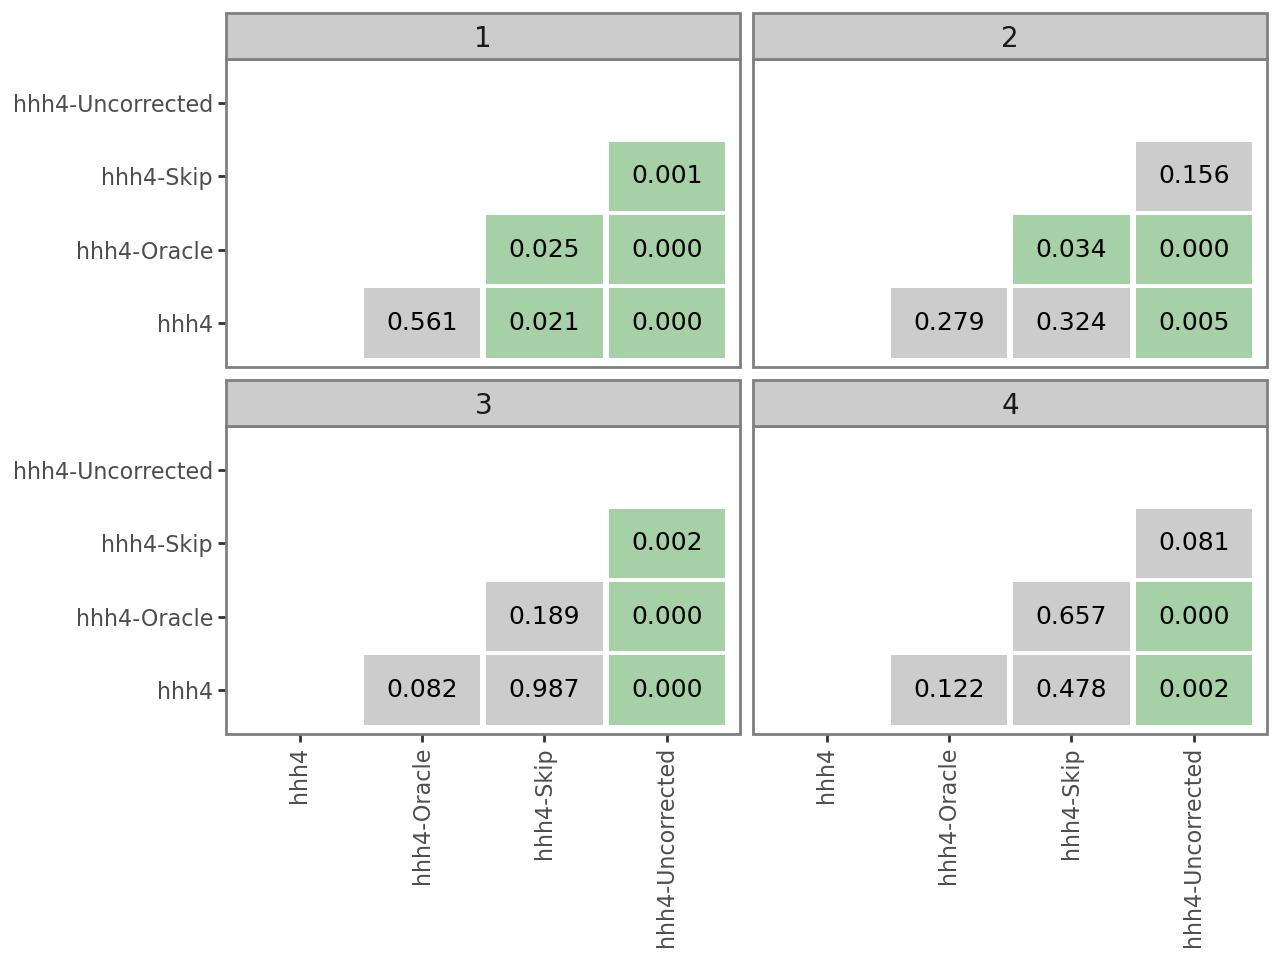

In [74]:
p = (
    ggplot(d1, aes('m2', 'm1'))
    + facet_wrap('horizon', ncol=2)
    + geom_tile(aes(fill='sig'), width=0.95, height=0.95, alpha=0.4, show_legend=False)
    + geom_text(aes(label='pval_two_sided'), format_string='{:.3f}', size=9)
    + scale_fill_manual(values={True:'#228B22', False:'gray'}, na_value='white')
    + scale_x_discrete(limits=MAIN_MODEL_ORDER, drop=False)
    + scale_y_discrete(limits=MAIN_MODEL_ORDER, drop=False)
    + theme_bw()
    + theme(panel_grid=element_blank(),
        plot_title=element_text(size=11),
        strip_text=element_text(size=10),
        legend_title=element_text(size=9),           
        legend_text=element_text(size=8),
        axis_title=element_text(size=10),
        axis_text_x=element_text(size=8, rotation=90, ha='center', ma='right'),
        axis_text_y=element_text(size=8)
    )
    + labs(x='', y='')
)
p

In [46]:
p.save("../figures/dm_test.pdf", width = 160, height = 140, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 160.0 x 140.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/dm_test.pdf


In [144]:
variant_order = ['Coupling', 'Oracle', 'Discard', 'Naive']
dict_variants = {"": "Coupling", "Oracle": "Oracle", "Skip": "Discard", "Uncorrected": "Naive"}

def variant_label(name: str) -> str:
    suffix = name.partition("-")[2]
    return dict_variants[suffix]

In [182]:
def plot_diebold_mariano(models, variants=False):
    
    df = load_predictions()
    df = df[df.model.isin(models)].copy()
    model_order = [m for m in MODEL_ORDER if m in models]
    df['model'] = pd.Categorical(df['model'], categories=model_order, ordered=True) 
    


    df_national = filter_by_level(df, 'national')
    df_wis = compute_wis_raw(df_national)
    df = df_wis.groupby(['location', 'age_group', 'model', 'date', 'horizon'], observed=True)['wis'].mean().reset_index()

    df.date = pd.to_datetime(df.date)
    df = df[(df.horizon > 0) & (df.horizon <= df.groupby('model', observed=False)['horizon'].max().min())]
    
    df_results = pd.DataFrame()
    for m1, m2 in combinations(model_order, 2):
        # print(f'{m1} vs {m2}')
        df_temp = df[df.model.isin([m1, m2])]
        df_temp = df_temp.pivot(index=['location', 'age_group', 'date', 'horizon'], 
                            columns='model', values='wis').rename_axis(columns=None).reset_index()
        df_temp['score_diff'] = df_temp[m1] - df_temp[m2]
        df_temp = (df_temp
                   .pivot(index="date", columns="horizon", values="score_diff")
                   .rename_axis(index="valid_date")      
                   .sort_index()
                   .dropna()
                  )

        da = xr.DataArray(
            data=df_temp.T.to_numpy(),              
            dims=["horizon", "valid_date"],
            coords={
                "horizon": df_temp.columns.astype(int),
                "valid_date": ("valid_date", pd.to_datetime(df_temp.index)),
                "h": ("horizon", df_temp.columns.astype(int))
            },
            name="score_diff"
        )

        results = statistical_tests.diebold_mariano(da, ts_dim="horizon", h_coord="h")
        results = results[['horizon', 'confidence_gt_0']].to_pandas().reset_index()
        results['m1'] = m1
        results['m2'] = m2
        df_results = pd.concat([df_results, results], ignore_index=True)

    df_results = df_results.rename(columns={'confidence_gt_0' : 'pval'})

    df_results['pval_two_sided'] = 2 * np.minimum(df_results['pval'], 1 - df_results['pval'])

    d1 = df_results.copy()
    d1['m1'] = pd.Categorical(d1['m1'], categories=model_order, ordered=True)
    d1['m2'] = pd.Categorical(d1['m2'], categories=model_order[::-1], ordered=True)
    d1['sig'] = d1['pval_two_sided'] < 0.05
    
    xkw = {"limits": model_order, "drop": False}
    ykw = {"limits": model_order, "drop": False}
    if variants:
        xkw["labels"] = lambda xs: [variant_label(x) for x in xs]
        ykw["labels"] = lambda ys: [variant_label(y) for y in ys]

    p = (
        ggplot(d1, aes('m2', 'm1'))
        + facet_wrap('horizon', ncol=2, labeller=lambda x: 'Horizon: ' + str(x))
        + geom_tile(aes(fill='sig'), width=0.95, height=0.95, alpha=0.4, show_legend=False)
        + geom_text(aes(label='pval_two_sided'), format_string='{:.3f}', size=7)
        + scale_fill_manual(values={True:'#228B22', False:'gray'}, na_value='white')
        + scale_x_discrete(**xkw)   # ← conditional labels
        + scale_y_discrete(**ykw)   # ← conditional labels
        + theme_bw()
        + theme(panel_grid=element_blank(),
            plot_title=element_text(size=11),
            strip_text=element_text(size=9),
            legend_title=element_text(size=9),           
            legend_text=element_text(size=8),
            axis_title=element_text(size=10),
            axis_text_x=element_text(size=8, rotation=90, ha='center', ma='right'),
            axis_text_y=element_text(size=8)
        )
        + labs(x='', y='', title=models[0] if variants else '')
    )
    
    return p

In [183]:
hhh4_variants = ['hhh4', 'hhh4-Oracle', 'hhh4-Skip', 'hhh4-Uncorrected']
lightgbm_variants = ['LightGBM', 'LightGBM-Oracle', 'LightGBM-Skip', 'LightGBM-Uncorrected']
tsmixer_variants = ['TSMixer', 'TSMixer-Oracle', 'TSMixer-Skip', 'TSMixer-Uncorrected',]

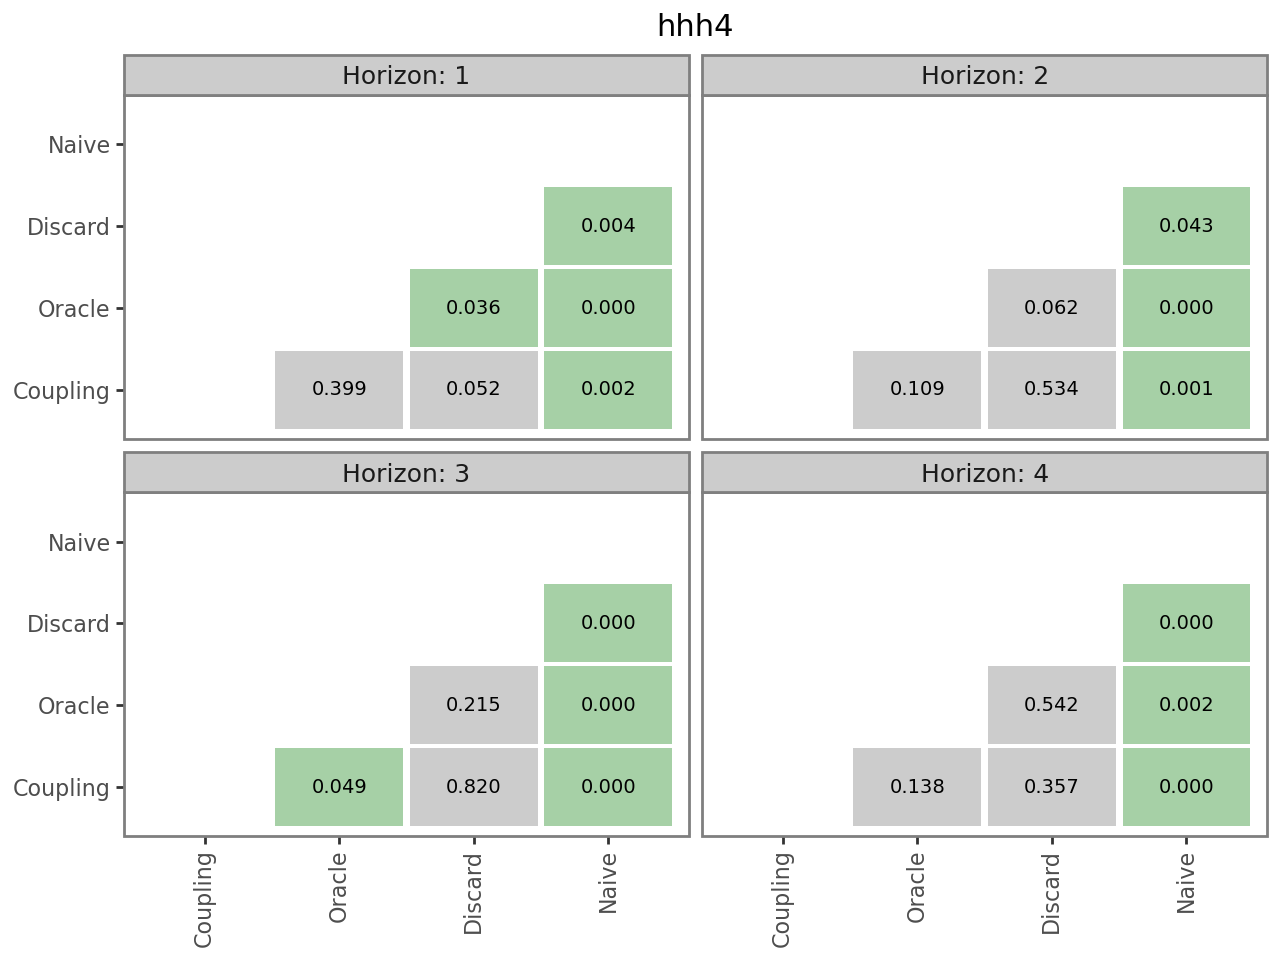

In [184]:
p = plot_diebold_mariano(hhh4_variants, True)
p

In [185]:
p.save("../figures/dm_test_hhh4.pdf", width = 95, height = 80, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 95.0 x 80.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/dm_test_hhh4.pdf


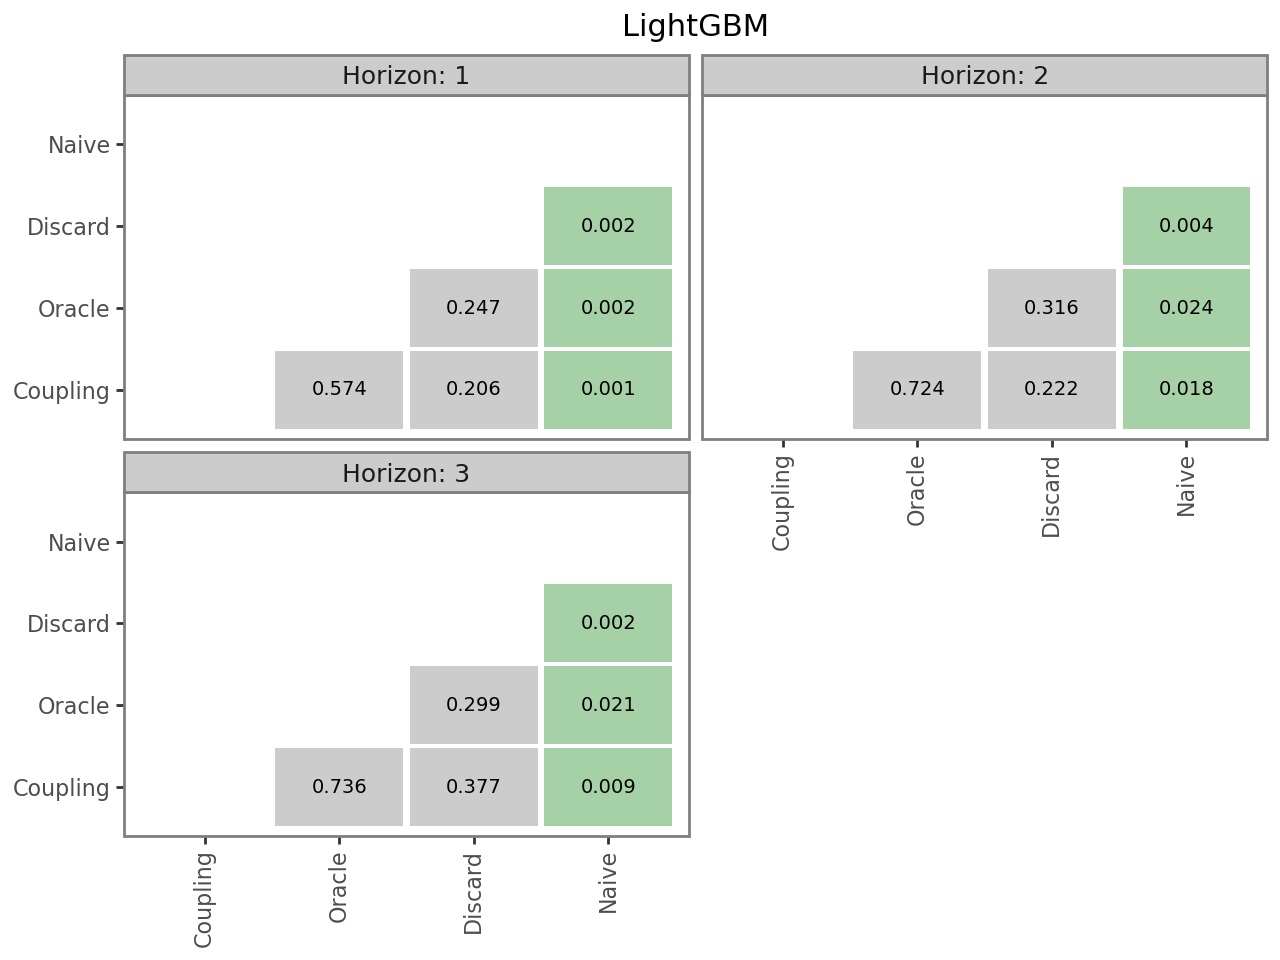

In [186]:
p = plot_diebold_mariano(lightgbm_variants, True)
p

In [187]:
p.save("../figures/dm_test_lightgbm.pdf", width = 95, height = 80, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 95.0 x 80.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/dm_test_lightgbm.pdf


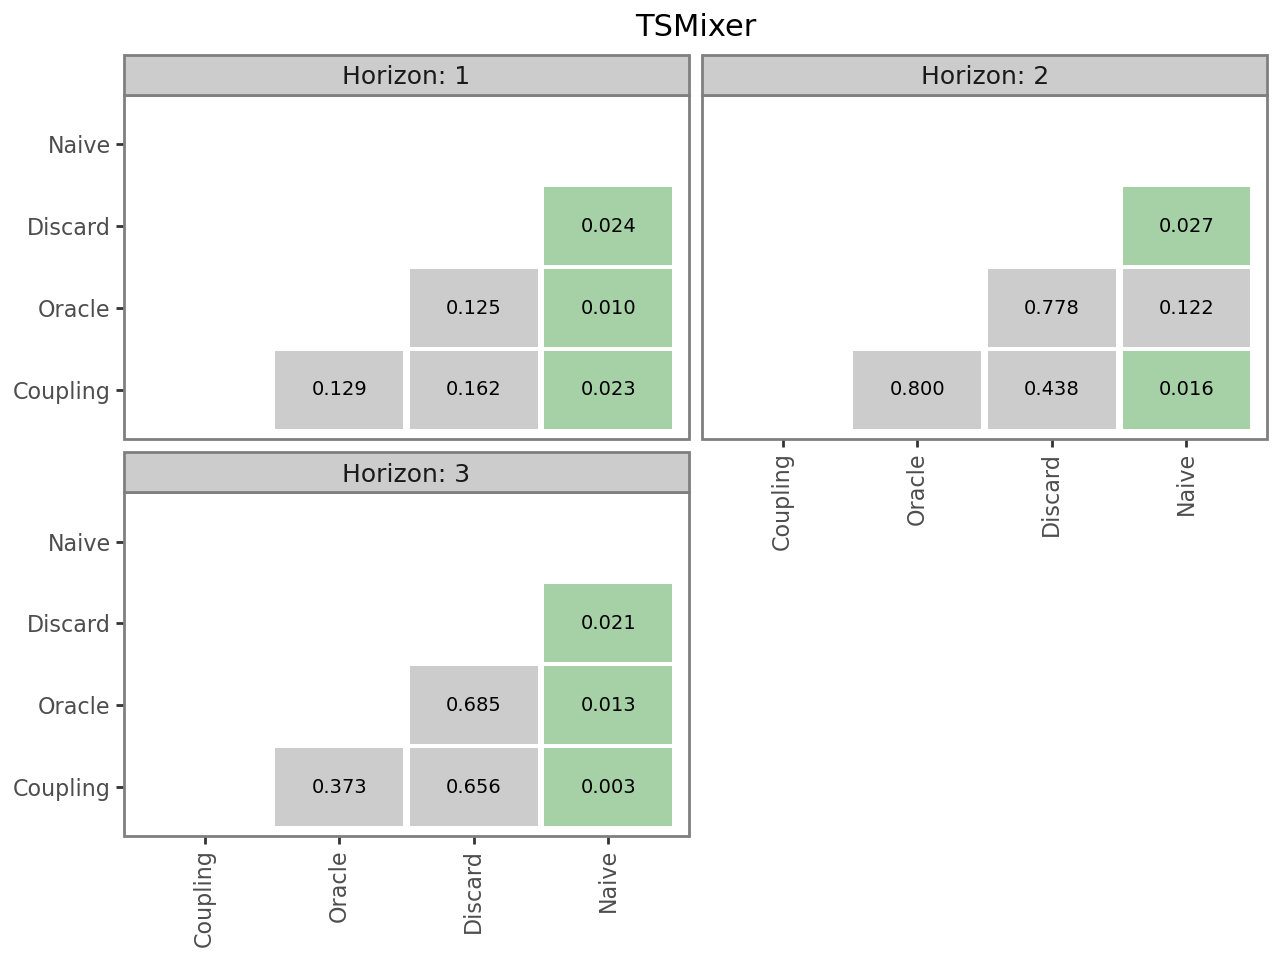

In [188]:
p = plot_diebold_mariano(tsmixer_variants, True)
p

In [189]:
p.save("../figures/dm_test_tsmixer.pdf", width = 95, height = 80, units="mm", dpi=600)

/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 95.0 x 80.0 mm image.
/home/wolffram/.conda/envs/RESPINOW-ML/lib/python3.9/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../figures/dm_test_tsmixer.pdf


In [27]:
def dm_upper(df, horizon, val='pval_two_sided'):
    """Return upper-triangle matrix of two-sided p-values for a given horizon."""
    d = df.loc[df['horizon'] == horizon, ['m1', 'm2', val]].copy()
    #models = sorted(pd.unique(pd.concat([d['m1'], d['m2']])))
    models = MAIN_MODELS
    mat = pd.DataFrame(np.nan, index=models, columns=models, dtype=float)

    pos = {m: i for i, m in enumerate(models)}

    for _, r in d.iterrows():
        i, j, p = r['m1'], r['m2'], r[val]
        if i == j:
            continue  # ignore self comparisons
        if pos[i] > pos[j]:  # write to upper triangle
            i, j = j, i
        mat.loc[i, j] = p

    return  mat.round(5)

In [28]:
dm_upper(df_results, 1)

,Ensemble,LightGBM,TSMixer,hhh4,Historical,Persistence
Ensemble,NaN,0.79622,0.00048,0.79990,0.00000,0.33218
LightGBM,NaN,NaN,0.43157,0.96994,0.00000,0.33799
TSMixer,NaN,NaN,NaN,0.05755,0.00001,0.81760
hhh4,NaN,NaN,NaN,NaN,0.00001,0.19487
Historical,NaN,NaN,NaN,NaN,NaN,0.00000
Persistence,NaN,NaN,NaN,NaN,NaN,NaN
